<a href="https://colab.research.google.com/github/dimageneer/AIEFFEL_QUEST/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_2%EC%9D%BC%EC%B0%A8_%EC%84%B1%EB%8A%A5_%EA%B7%B9%EB%8C%80%ED%99%94%EB%A5%BC_%EC%9C%84%ED%95%9C_%ED%8A%9C%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 바이크 수요 예측 모델 하이퍼파라미터 튜닝과 모델 해석

Recap: 1일차의 발견

1일차 실습에서 우리는 바이크 수요 예측 문제를 다루며 다음과 같은 중요한 사실을 발견했습니다:

- EDA의 중요성: 시간, 계절, 온도 등 다양한 변수들이 자전거 수요에 비선형적(Non-linear)인 관계를 맺고 있음을 확인했습니다.
- 모델별 성능 차이: 선형 모델은 낮은 성능을 보인 반면, 트리 기반 앙상블 모델(Random Forest, Gradient Boosting)은 훨씬 뛰어난 예측 성능을 보였습니다.
- 귀납적 편향: 이는 트리 모델의 귀납적 편향이 우리 데이터의 실제 패턴과 잘 부합했기 때문입니다.

🎯 2일차 목표

2일차에는 그래디언트 부스팅 모델을 선택하여, 다음과 같은 심화 과정을 진행합니다.

- 더 신뢰성 있는 모델 평가: 교차 검증(Cross-Validation)을 적용합니다.
- 최적의 모델 탐색: 하이퍼파라미터 튜닝(Grid Search)으로 성능을 극대화합니다.
- 모델 해석 (XAI): 특성 중요도와 부분 의존성 그림(PDP)으로 '블랙박스'를 열어봅니다.

데이터셋은 1일차와 같습니다

https://www.kaggle.com/competitions/bike-sharing-demand/data?select=train.csv

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 훈련 데이터 로드 및 전처리

간단히 데이터를 로드하고, 빠르게 전처리를 진행해볼까요?

1. `temp`와 역할이 거의 같은 'atemp'와, 1일차 파악했던 'humidity', 'casual', 그리고 'registered' 칼럼은 제거하겠습니다.

In [20]:
train_df = pd.read_csv('./train.csv')

In [21]:
# datetime 컬럼을 datetime 자료형으로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# datetime 정보를 연, 월, 일, 시로 분리하여 새로운 열 생성 (분, 초는 의미가 없었죠)
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
dtypes: datetime64[ns](1), 

In [24]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['datetime', 'count', 'casual', 'registered', 'humidity', 'atemp'], axis=1)
y = train_df['count']

# RMSLE 지표

1일차에 잠시 나왔던 RMSLE는 skewed 분포를 정확하게 추정하는 지표입니다.

로그를 취해 계산하여 일부 큰 값의 오차에 모델이 과도하게 영향 받는 것을 방지하고, 과소 예측에 큰 페널티를 부여해 수요 예측 문제에 적절한 지표로 활용됩니다.

In [25]:
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    log_true = np.log1p(np.maximum(y_true, 0))
    log_pred = np.log1p(np.maximum(y_pred, 0))
    squared_error = (log_true - log_pred) ** 2
    return np.sqrt(np.mean(squared_error))

# Scikit-learn에서 사용 가능하도록 scorer 생성
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
print("RMSLE Scorer가 성공적으로 생성되었습니다.")

RMSLE Scorer가 성공적으로 생성되었습니다.


# K-Fold 교차 검증

1일차에는 `train_test_split` 메서드를 통해 데이터를 분할했지만, 이러한 단일 데이터 분할은 우연에 의한 성능 왜곡이 가능합니다!

K-Fold 교차 검증은 데이터를 K개의 그룹으로 나누어 K번 학습과 검증을 반복하고 평균을 내는 방식으로, 더 신뢰도 높은 성능을 제공합니다.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# 기본 파라미터의 그래디언트 부스팅 모델
gbr = GradientBoostingRegressor(random_state=42)

def k_fold_cross_validation(model, X, y, n_splits=5):
  scores = cross_val_score(model, X, y, cv=n_splits, scoring=rmsle_scorer)
  mean_score = -np.mean(scores)
  print(f"교차 검증 폴드별 RMSLE 점수: {-scores}")
  print(f"\\n평균 RMSLE 점수 (기본 모델): {mean_score:.4f}")

k_fold_cross_validation(gbr, X, y)

교차 검증 폴드별 RMSLE 점수: [0.89628189 0.63429127 0.85804399 0.65853071 0.61655084]
\n평균 RMSLE 점수 (기본 모델): 0.7327


# 하이퍼파라미터 튜닝으로 성능 극대화

K-Fold 교차 검증을 통해 보니, 여러 데이터 분할에 따라서 성능이 천차만별이라는 것을 확인했습니다!

또한, 모델을 정의하는 하이퍼파라미터에 따라서도 성능이 달라지는 것을 확인할 수 있는데, 직접 모두 다 일일히 테스트 해야할까요?

sklearn의 `GridSearchCV`는 이러한 역할을 자동화해줍니다!

하이퍼파라미터 경우의수를 늘릴수록 시간이 그만큼 오래 걸린다는 단점... 당연하지만 꼭 유념해두어야 하겠죠?

In [27]:
from sklearn.model_selection import GridSearchCV

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 그리드 서치 실행 (시간이 다소 소요될 수 있습니다)
grid_search.fit(X, y)

print(f"\\n최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최적 파라미터 적용 시 RMSLE 점수: {-grid_search.best_score_:.4f}")

# 최적의 모델 저장
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
\n최적의 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
최적 파라미터 적용 시 RMSLE 점수: 0.6209


# 모델의 속마음 들여다보기

최적의 파라미터와 그에 따른 RMSLE 성능을 확인하셨나요? 좋습니다!

그런데, 그 하이퍼파라미터 설정에서 모델이 뭘 했길래 그렇게 성능이 좋았을까요?

머신러닝은 예측 성능을 최대화 하는 것을 목표로 하지만, 그럼에도 불구하고 최고의 모델을 찾았다면, 이제 그 모델이 '왜' 그런 예측을 하는지 이해해야 합니다. 이는 비즈니스 의사결정과 모델의 신뢰성 확보에 매우 중요합니다.

### 특성 중요도 (Feature Importance)

그래디언트 부스팅 모델은 수많은 약한 결정 트리(weak learner)들로 구성되어 있습니다.

따라서 먼저 단일 트리에서 변수 중요도가 어떻게 계산되는지 이해해야 합니다.

1. 노드 분할과 불순도(Impurity): 결정 트리는 데이터를 가장 잘 나눌 수 있는 질문(예: hour < 8)을 던져가며 성장합니다. 이때 '잘 나눈다'의 기준이 바로 불순도를 얼마나 많이 줄일 수 있는가입니다. 회귀 문제에서는 이 불순도를 보통 **평균 제곱 오차(MSE)**로 측정합니다.

2. 불순도 감소량 계산: 특정 변수를 사용해 노드를 분할했을 때, 그 변수의 중요도는 다음과 같이 계산됩니다.

- 불순도 감소량 = (부모 노드의 MSE) - (왼쪽 자식 노드의 가중 평균 MSE + 오른쪽 자식 노드의 가중 평균 MSE)
- 예를 들어, hour < 8이라는 질문으로 노드를 나눴더니 자식 노드들의 오차 합이 부모 노드의 오차보다 크게 줄었다면, hour 변수는 그 분기에서 매우 중요한 역할을 한 것입니다. 이 '오차가 줄어든 양'이 바로 해당 분기에서의 변수 중요도입니다.

___

이제 이 원리를 수백 개의 트리로 구성된 그래디언트 부스팅 모델 전체로 확장합니다.

1. 개별 트리의 중요도 합산: 먼저, 모델을 구성하는 하나의 트리 안에서 특정 변수(예: hour)의 총 중요도를 계산합니다. 이는 해당 트리 내에서 hour 변수가 사용된 모든 분기(split)의 '불순도 감소량'을 전부 더한 값입니다.
2. 전체 트리의 평균: 그 다음, 모델을 구성하는 모든 트리에 대해 이 과정을 반복합니다. 최종적으로 hour 변수의 중요도는 모든 트리에 걸쳐 계산된 hour의 평균 중요도가 됩니다.
3. 정규화: 마지막으로, 모든 변수들의 중요도 합이 1이 되도록 전체 값을 정규화(normalize)합니다.

이론을 이야기하니 매우 어렵네요!

어떤 요소가 바이크 수요 예측에 가장 핵심적이었을까요?

___




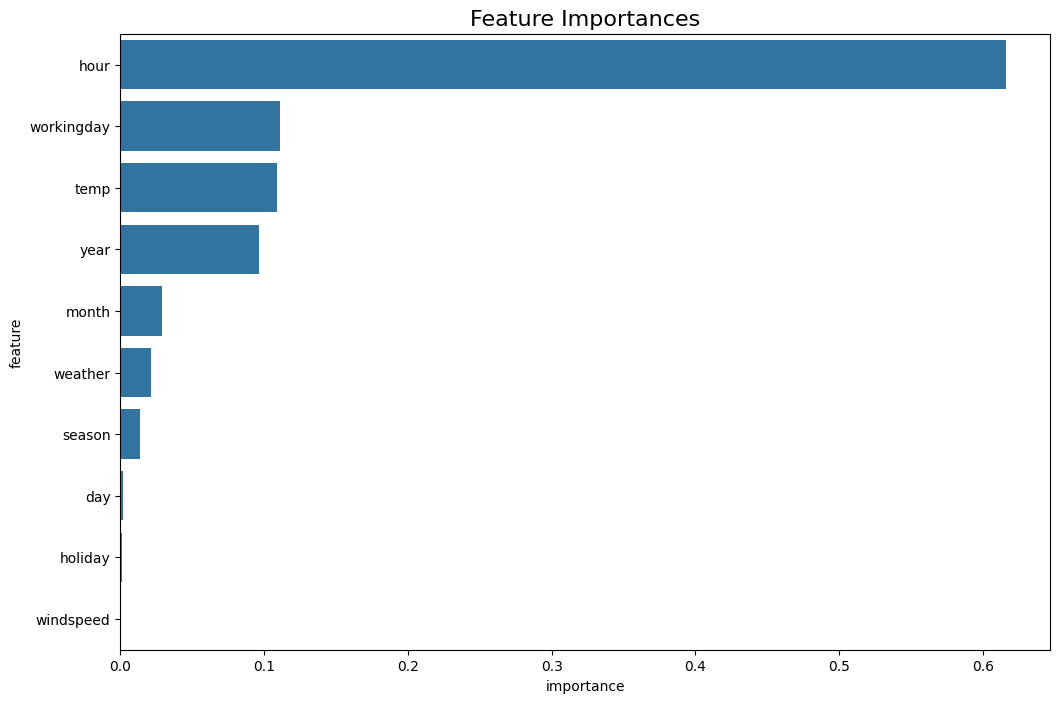

In [28]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances', fontsize=16)
plt.show()

`hour`(시간)가 압도적으로 가장 중요한 변수이며, `workingday`(근무일 여부), `year`(연도), `temp`(온도) 등이 그 뒤를 잇고 있네요.

1일차에서 진행했던 간단한 EDA로는 미처 확인하지 못하고 지나갔을 수도 있지만, 학습을 진행하고 모델을 뜯어보니 새로운 정보를 확인할 수 있네요!

### 부분 의존성 (Partial Dependence Display)

PDP는 '그 변수가 예측에 어떻게 영향을 미치는지' 관계의 형태를 직접 보여줍니다.

다른 말로, 다른 모든 변수들의 효과를 평균내서 지워버릴 때, 오직 이 변수 하나만 바꾸면 어떻게 예측값이 변할지를 묻는게 PDP입니다!

PDP를 통해 1일차에 선형 모델이 왜 실패했는지 (왜 오차가 매우 컸는지) 명확하게 이해할 수 있습니다.

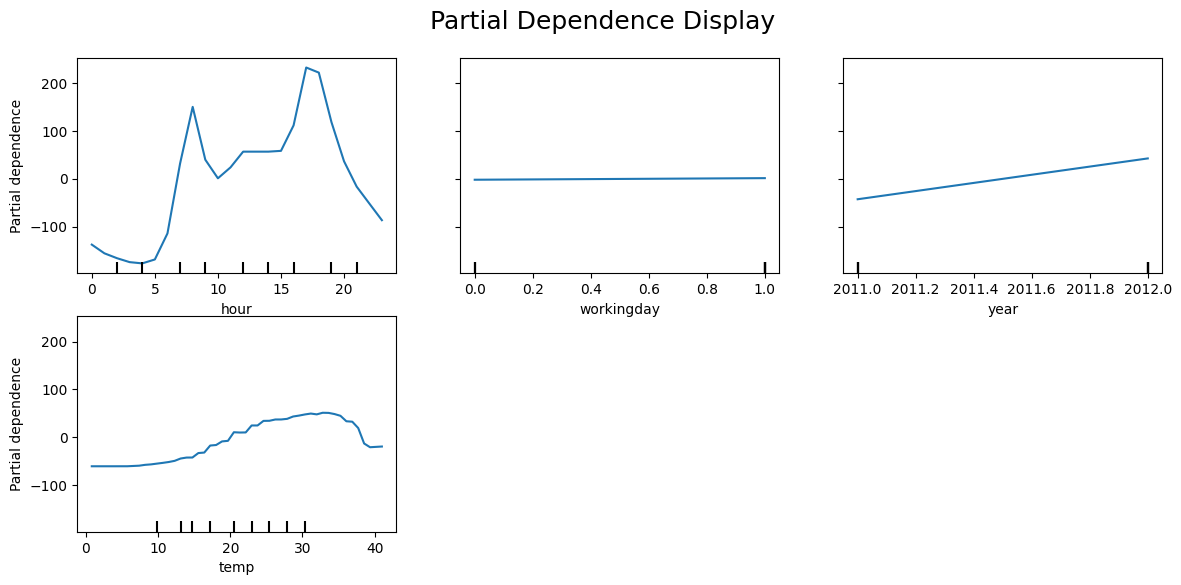

In [29]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(14, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X,
    features=['hour', 'workingday', 'year', 'temp'],
    feature_names=X.columns, # Add feature_names parameter
    ax=ax
)
fig.suptitle('Partial Dependence Display', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

Feature Importance에서는 크게 나타났던 `workingday`랑 `year`가 PDP 관점에서는 크게 변하지 않는 것 같습니다. 왜 이럴까요?

1. 부스팅 초기에 전역적인 효과로 작용했다면, 즉 '전체 분산을 크게 줄이는 데' 효과적이라면 부분적인 효과는 당연히 줄어들겠죠? 아마 2011년인지, 2012년인지 이 이진 분류 만으로도 모델은 빠르게 경향성을 파악하는데 성공했을 겁니다.

2. 너무나 상호작용이 강했을지도 모릅니다. `workingday`는 다른 변수와 밀접한 관련을 맺고 있는 것이죠!


### [결과 해석]

  - `hour` : 오전 8시와 오후 5-6시에 뚜렷한 피크를 보이는 강한 비선형 패턴(출퇴근)을 보입니다.
  - `temp` : 온도가 너무 낮으면 수요가 적다가, 20-30도 사이에서 가장 높고, 더 더워지면 감소하는 곡선 형태의 관계를 보입니다.
이러한 복잡한 패턴들은 선형 모델이 학습하기 어렵기 때문에 트리 기반 모델이 우수한 성능을 보인 것입니다.

# 결론 !

2일차 실습을 통해 우리는 다음과 같은 중요한 머신러닝 워크플로우를 경험했습니다.

1. 신뢰성 있는 평가: 교차 검증과 RMSLE 지표로 모델을 객관적으로 평가했습니다.
성능 극대화: Grid Search로 하이퍼파라미터를 튜닝하여 성능을 개선했습니다.
2. 결과에 대한 설명: 특성 중요도와 PDP를 통해 단순히 "이 모델이 좋다"를 넘어 "왜 좋은지"를 설명할 수 있게 되었습니다.

이러한 과정은 실제 현업에서 머신러닝 모델을 개발하고, 그 결과를 설득력 있게 전달하는 데 필수적인 역량입니다. 고생하셨습니다!